In [36]:
import json
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    GlobalAveragePooling1D,
    Input,
    LayerNormalization,
    MultiHeadAttention,
)
from tensorflow.keras.models import Model

# Load data from JSON file
with open("data.json") as f:
    data = json.load(f)

# Dữ liệu bạn đã cung cấp
closing_prices = np.array(data["c"]).reshape(
    -1, 1
)  # Giả sử 'data' là từ JSON bạn đã cung cấp

# Chuẩn bị dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(closing_prices)


def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i : (i + time_step), 0]  # X: dữ liệu đầu vào
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Y: giá trị dự đoán tiếp theo
    return np.array(dataX), np.array(dataY)


# Tạo dữ liệu đào tạo và kiểm tra
time_step = 4  # Sử dụng 4 giá đóng cửa trước đó để dự đoán giá tiếp theo
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Thay đổi hình dạng cho mô hình


# Khối Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(
        x, x
    )
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res


# Định nghĩa mô hình
inputs = Input(shape=(X.shape[1], X.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format="channels_first")(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Tóm tắt mô hình
model.summary()

# Đào tạo mô hình
# Chú ý: Trong môi trường này, chúng ta không thể thực sự đào tạo mô hình
model.fit(X, y, epochs=100, batch_size=512, verbose=1)

# Dự đoán
predicted_price = model.predict(X[-1].reshape(1, time_step, 1))
predicted_price = scaler.inverse_transform(
    predicted_price
)  # Chuyển ngược lại giá trị ban đầu
print(f"Predicted next close price: {predicted_price[0][0]}")

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 4, 1)]               0         []                            
                                                                                                  
 layer_normalization_14 (La  (None, 4, 1)                 2         ['input_12[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_8 (Mu  (None, 4, 1)                 7169      ['layer_normalization_14[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_14

In [37]:
# Đảm bảo rằng model của bạn đã được đào tạo và scaler đã được fit với dữ liệu

num_predictions = 200
results = []

# Sử dụng 4 giá đóng cửa cuối cùng từ dữ liệu ban đầu để bắt đầu quá trình dự đoán
last_sequence = data_scaled[
    -time_step:
]  # `time_step` được giả định là 4 trong trường hợp này

# Lặp qua số lượng dự đoán bạn muốn tạo
for _ in range(num_predictions):
    # Dự đoán sử dụng mô hình với dữ liệu đầu vào hiện tại
    predicted_price_scaled = model.predict(last_sequence.reshape(1, time_step, 1))

    # Thêm dự đoán vào kết quả (chúng ta cần chuyển đổi nó về dạng ban đầu)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
    results.append(predicted_price)

    # Chuẩn bị chuỗi dữ liệu đầu vào tiếp theo bằng cách thêm dự đoán vào cuối
    # và loại bỏ giá trị đầu tiên
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = predicted_price_scaled

# `results` chứa giá dự đoán cho 200 ngày tiếp theo
print(results)

1/1 [==============================] - 0s 15ms/step
[1287.8163, 1288.8696, 1292.7012, 1299.5477, 1308.7838, 1313.777, 1319.5961, 1325.8347, 1331.764, 1337.0896, 1342.4653, 1347.7188, 1352.7411, 1357.5729, 1362.2844, 1366.8405, 1371.2375, 1375.4924, 1379.6135, 1383.5985, 1387.4525, 1391.1818, 1394.79, 1398.2803, 1401.6569, 1404.9233, 1408.0836, 1411.1409, 1414.0986, 1416.96, 1419.7283, 1422.406, 1424.997, 1427.5034, 1429.9281, 1432.274, 1434.5432, 1436.7388, 1438.8627, 1440.9175, 1442.9053, 1444.8286, 1446.689, 1448.4889, 1450.2301, 1451.9146, 1453.5442, 1455.121, 1456.646, 1458.1216, 1459.5491, 1460.93, 1462.2662, 1463.5587, 1464.809, 1466.0186, 1467.189, 1468.3209, 1469.4161, 1470.4758, 1471.501, 1472.4928, 1473.452, 1474.3802, 1475.2781, 1476.1467, 1476.9872, 1477.8002, 1478.5865, 1479.3475, 1480.0835, 1480.7955, 1481.4846, 1482.151, 1482.7959, 1483.4196, 1484.0231, 1484.6068, 1485.1718, 1485.718, 1486.2466, 1486.758, 1487.2528, 1487.7314, 1488.1945, 1488.6425, 1489.0757, 1489.4951, 

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Đánh giá RMSE và MAE trên tập dữ liệu đã được đào tạo
train_predictions = model.predict(X)
train_predictions = scaler.inverse_transform(
    train_predictions
)  # Chuyển về giá trị ban đầu
train_true_values = scaler.inverse_transform(
    y.reshape(-1, 1)
)  # Chuyển về giá trị ban đầu

train_rmse = mean_squared_error(train_true_values, train_predictions, squared=False)
train_mae = mean_absolute_error(train_true_values, train_predictions)

print("Train RMSE:", train_rmse)
print("Train MAE:", train_mae)

# # Dự đoán 200 ngày tiếp theo
# num_predictions = 200
# predicted_prices_scaled = []
# last_sequence = data_scaled[-time_step:].reshape(1, time_step, 1)

# for _ in range(num_predictions):
#     predicted_price_scaled = model.predict(last_sequence)
#     predicted_prices_scaled.append(predicted_price_scaled)
#     last_sequence = np.roll(last_sequence, -1)
#     last_sequence[-1] = predicted_price_scaled

# # Chuyển đổi dự đoán về dạng ban đầu
# predicted_prices = scaler.inverse_transform(
#     np.array(predicted_prices_scaled).reshape(-1, 1)
# )

180/180 [==============================] - 2s 8ms/step
Train RMSE: 73.60275952476472
Train MAE: 67.45214591194033


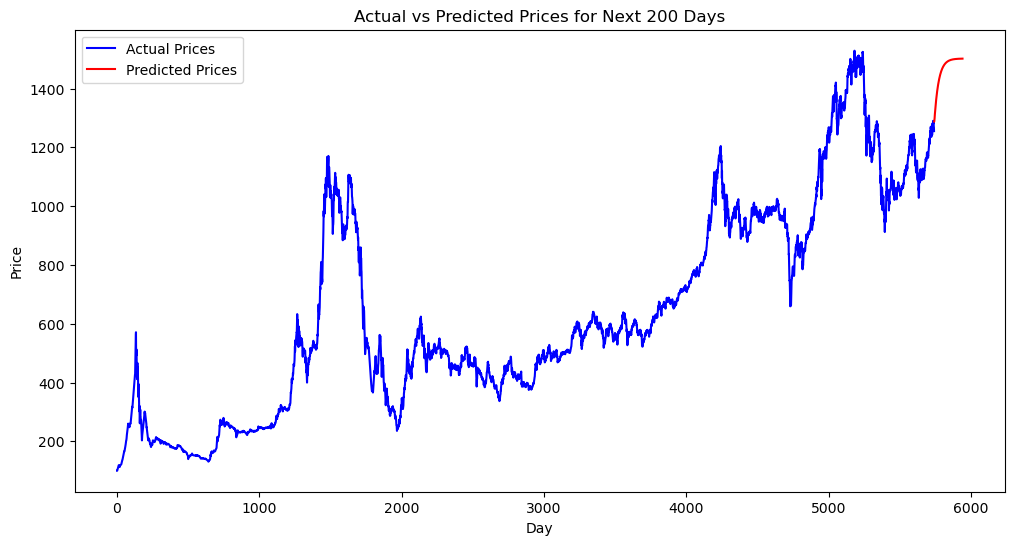

In [41]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(closing_prices, label="Actual Prices", color="blue")
plt.plot(
    np.arange(len(data_scaled), len(data_scaled) + num_predictions),
    results,
    label="Predicted Prices",
    color="red",
)
plt.title("Actual vs Predicted Prices for Next 200 Days")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()